In [1]:
%pip install pycocotools safetensors

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os 

# Use local dataset path from kagglehub download
base_path = "/home/loc-dang/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2/coco2017"
print("Annotations:", os.listdir(os.path.join(base_path, "annotations")))
print("Training images:", len(os.listdir(os.path.join(base_path, "train2017"))))
print("Validation images:", len(os.listdir(os.path.join(base_path, "val2017"))))
print("Test images:", len(os.listdir(os.path.join(base_path, "test2017"))))

Annotations: ['captions_val2017.json', 'instances_val2017.json', 'captions_train2017.json', 'person_keypoints_val2017.json', 'instances_train2017.json', 'person_keypoints_train2017.json']


Training images: 118287
Validation images: 5000
Test images: 40670


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

In [5]:
# Test DoubleConv block
print("🧪 Testing DoubleConv:")
test_input = torch.randn(1, 3, 100, 100)  # [batch, channels, height, width]
double_conv = DoubleConv(3, 64)
output = double_conv(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Size change: {test_input.shape[-1]} -> {output.shape[-1]}")
print(f"Pixels lost: {test_input.shape[-1] - output.shape[-1]} (due to unpadded conv)")

🧪 Testing DoubleConv:
Input shape: torch.Size([1, 3, 100, 100])
Output shape: torch.Size([1, 64, 96, 96])
Size change: 100 -> 96
Pixels lost: 4 (due to unpadded conv)


In [6]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x):
        x = self.max_pool(x)
        x = self.double_conv(x)
        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        batch, channels, x2_height,x2_width = x2.shape
        up_sample = self.up_conv(x1)
        each_size = (x2_height - up_sample.shape[2]) // 2  

        x2_crop = x2[:,:,each_size:x2_height - each_size, each_size:x2_width - each_size]
        concatenate = torch.cat([up_sample, x2_crop], dim=1)

        return self.double_conv(concatenate)

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()

        self.encoder_0 = DoubleConv(in_channels=in_channels, out_channels=64)
        self.encoder_1 = Encoder(64, 128)
        self.encoder_2 = Encoder(128, 256)
        self.encoder_3 = Encoder(256, 512)
        self.encoder_4 = Encoder(512, 1024)

        self.decoder_0 = Decoder(1024, 512)
        self.decoder_1 = Decoder(512, 256)
        self.decoder_2 = Decoder(256, 128)
        self.decoder_3 = Decoder(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1, padding=0)

    def forward(self, x):
        x1 = self.encoder_0(x)
        x2 = self.encoder_1(x1)
        x3 = self.encoder_2(x2)
        x4 = self.encoder_3(x3)
        x5 = self.encoder_4(x4)

        x = self.decoder_0(x5, x4)
        x = self.decoder_1(x, x3)
        x = self.decoder_2(x, x2)
        x = self.decoder_3(x, x1)
        return self.out(x)



In [9]:
# Test UNet Architecture
print("🚀 Testing Complete U-Net:")

# Create model
model = UNet(in_channels=3, num_classes=2)  # RGB input, binary segmentation
print(f"Model created: {model.__class__.__name__}")

# Test with dummy input
test_input = torch.randn(1, 3, 572, 572)  # Original paper input size
print(f"Input shape: {test_input.shape}")

# Forward pass
with torch.no_grad():
    output = model(test_input)
    
print(f"Output shape: {output.shape}")
print(f"Input size: {test_input.shape[-1]} -> Output size: {output.shape[-1]}")
print(f"Size reduction: {test_input.shape[-1] - output.shape[-1]} pixels")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"Total: {total_params:,}")
print(f"Trainable: {trainable_params:,}")

🚀 Testing Complete U-Net:
Model created: UNet
Input shape: torch.Size([1, 3, 572, 572])
Output shape: torch.Size([1, 2, 388, 388])
Input size: 572 -> Output size: 388
Size reduction: 184 pixels

Model Parameters:
Total: 31,031,810
Trainable: 31,031,810


In [ ]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WeightedCrossEntropyLoss, self).__init__()
    
    def forward(self, logits, targets, weight_map=None):
        probabilities = F.softmax(logits, dim=1)
        loss = F.cross_entropy(probabilities, targets, reduction='none')
        if weight_map is not None:
            loss = loss * weight_map
        return loss.mean()

In [22]:
# Test WeightedCrossEntropyLoss
print("🧪 Testing WeightedCrossEntropyLoss:")

# Create dummy data
batch_size, num_classes, height, width = 2, 3, 10, 10
logits = torch.randn(batch_size, num_classes, height, width)
targets = torch.randint(0, num_classes, (batch_size, height, width))
weight_map = torch.ones(batch_size, height, width)

print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Weight map shape: {weight_map.shape}")

# Test loss
criterion = WeightedCrossEntropyLoss()
loss_without_weights = criterion(logits, targets)
loss_with_weights = criterion(logits, targets, weight_map)

print(f"\nLoss without weights: {loss_without_weights.item():.4f}")
print(f"Loss with weights: {loss_with_weights.item():.4f}")
print("✅ Loss function works!")

🧪 Testing WeightedCrossEntropyLoss:
Logits shape: torch.Size([2, 3, 10, 10])
Targets shape: torch.Size([2, 10, 10])
Weight map shape: torch.Size([2, 10, 10])
hehe torch.Size([2, 3, 10, 10]) torch.Size([2, 10, 10])
hehe torch.Size([2, 3, 10, 10]) torch.Size([2, 10, 10])

Loss without weights: 1.1051
Loss with weights: 1.1051
✅ Loss function works!


In [24]:
import cv2
import numpy as np
from scipy import ndimage
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

def generate_weight_map(mask, w0=10, sigma=5):
    """
    Generate weight map for U-Net training
    
    Args:
        mask: Binary mask [H, W] (0=background, 1=cell)
        w0: Weight of separation between cells
        sigma: Standard deviation for Gaussian
    
    Returns:
        weight_map: Weight map [H, W]
    """
    # Bước 1: Tính class weights wc(x)
    background_pixels = np.sum(mask == 0)
    foreground_pixels = np.sum(mask == 1)
    
    if foreground_pixels > 0:
        class_ratio = background_pixels / foreground_pixels
    else:
        class_ratio = 1.0
    
    # Tạo class weight map
    wc = np.ones_like(mask, dtype=np.float32)
    wc[mask == 1] = class_ratio  # Tăng weight cho foreground
    
    # Bước 2: Tính boundary weights (nếu có nhiều cells riêng biệt)
    # Đơn giản hóa: chỉ tính distance transform
    distance = distance_transform_edt(mask == 0)  # Distance từ background
    
    # Bước 3: Apply Gaussian weight tại boundaries
    boundary_weight = w0 * np.exp(-(distance**2) / (2 * sigma**2))
    
    # Bước 4: Combine weights
    weight_map = wc + boundary_weight
    
    return weight_map

def visualize_weight_map(mask, weight_map):
    """Visualize mask and weight map side by side"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original mask
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('Original Mask')
    axes[0].axis('off')
    
    # Weight map
    axes[1].imshow(weight_map, cmap='hot')
    axes[1].set_title('Weight Map')
    axes[1].axis('off')
    
    # Colorbar
    im = axes[2].imshow(weight_map, cmap='hot')
    axes[2].set_title('Weight Map (with colorbar)')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

🧪 Testing Weight Map Generation:
Mask shape: (100, 100)
Background pixels: 9200
Foreground pixels: 800
Weight map shape: (100, 100)
Weight range: 1.00 - 21.50


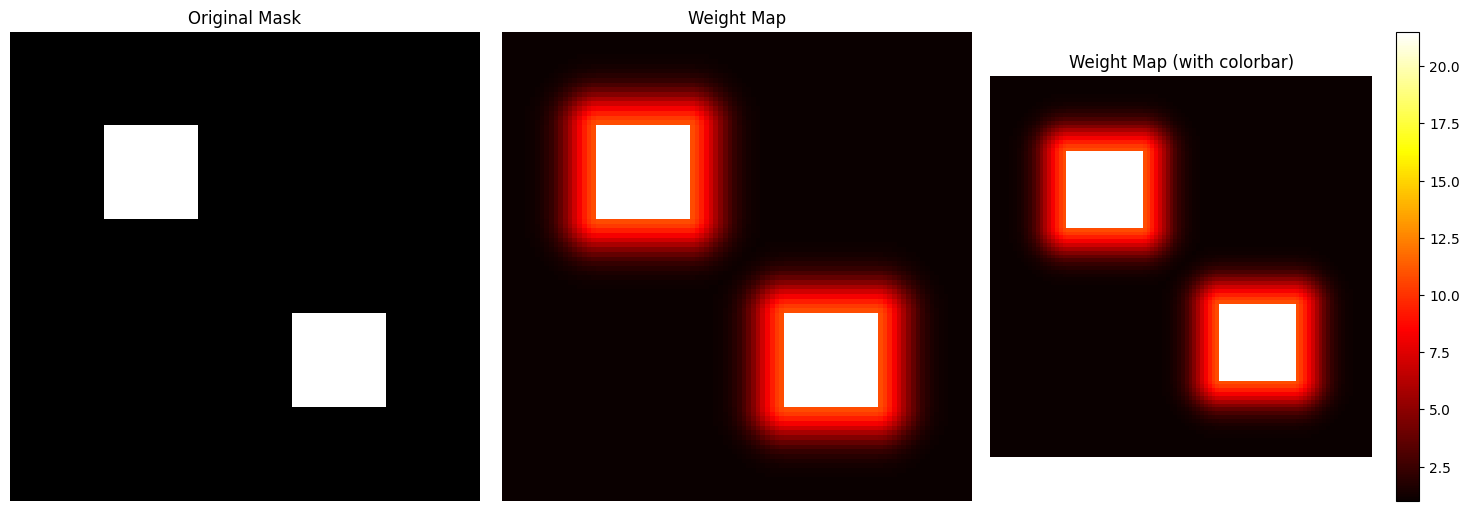

In [25]:
# Test Weight Map Generation
print("🧪 Testing Weight Map Generation:")

# Create dummy binary mask (simulating cells)
mask = np.zeros((100, 100), dtype=np.uint8)
mask[20:40, 20:40] = 1  # Cell 1
mask[60:80, 60:80] = 1  # Cell 2

print(f"Mask shape: {mask.shape}")
print(f"Background pixels: {np.sum(mask == 0)}")
print(f"Foreground pixels: {np.sum(mask == 1)}")

# Generate weight map
weight_map = generate_weight_map(mask, w0=10, sigma=5)
print(f"Weight map shape: {weight_map.shape}")
print(f"Weight range: {weight_map.min():.2f} - {weight_map.max():.2f}")

# Visualize
visualize_weight_map(mask, weight_map)

# Import dataset